In [4]:
%load_ext autoreload
%autoreload 2

import sys, os
import lightning.pytorch as pl
import torch
from matplotlib import pyplot as plt
import numpy as np
import pickle
from itertools import product, combinations_with_replacement
from skimage.morphology import disk, remove_small_objects
from skimage.measure import label, regionprops
from tqdm import tqdm
import pandas as pd 
from collections import defaultdict


sys.path.insert(1, sys.path[0] + '/..')
from src.data.datamodule import DataModule
from src.data.utils import simplify_labels
from src.model.setup import setup_model
from src.misc.utils import set_seed_and_precision
from src.misc.files import SetupArgs, read_image
from src.misc.post import calculate_metrics
from src.postprocess import _remove_low_probs, _remove_spine_fp, _remove_small_objects, _post_process
from src.postprocess import main as postprocess_main, parse_option as postprocess_parse_option

from src.run import parse_option, main
args = parse_option(notebook=True)
args.data_dir = '../data_dev'
args.version = 'version_elias'
args.num_workers = 8
args.max_epochs = 30

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Train

In [5]:
# a = torch.ones((3, 64, 64, 64))
# b = torch.tensor([[18, 17, 17],
#         [19, 17, 14],
#         [14, 16, 18]])

# for i, b_i in enumerate(b):
#     a[i, b_i[0]:, b_i[1]:, b_i[2]:] = -1

# print(a)

In [6]:
# a = torch.ones((3, 64, 64, 64))
# b = torch.tensor([[18, 17, 17],
#         [19, 17, 14],
#         [14, 16, 18]])

# aa = [a[i, :b_i[0], :b_i[1], :b_i[2]] for i, b_i in enumerate(b)]

# for a in aa:
#     print(a.shape)



In [7]:
args.train, args.predict = True, False
args.splits = ['train', 'val']
main(args)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name | Type              | Params
-------------------------------------------
0 | net  | UNet3D            | 5.0 M 
1 | loss | BCEWithIgnoreLoss | 0     
-------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.089    Total estimated model params size (MB)


Epoch 22:   0%|          | 0/4 [00:00<?, ?it/s, v_num=lias, train_loss=0.653, train_acc=0.982, val_loss=0.652, val_acc=0.987]        

/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Predict with custom loading

In [ ]:
# setup_args = SetupArgs(**{
#     'net' : 'unet3d',
#     'predict' : True,
#     'train' : False,
#     'log_dir' : '../logs',
#     'version' : 'version_sam',
# })

# trained_unet = setup_model(setup_args)

In [ ]:
# x = torch.randn(1, 32, 32, 32) # a random image
# y = torch.tensor([-1]) # a random label
# batch = (x, y)
# trained_unet(batch)

Predict directly in run

In [8]:
args.train, args.predict = False, True
args.splits = ['train']
main(args)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


In [ ]:
assert False

Post process

In [ ]:
postprocess_args = postprocess_parse_option(notebook=True)
postprocess_args.split = 'val'
postprocess_args.prediction_box_dir = os.path.join(args.log_dir, args.net, args.version, 'segmentations')
postprocess_args.original_image_dir = args.data_dir
postprocess_args.save_dir = os.path.join(args.log_dir, 'submissions', args.version, postprocess_args.split)

# postprocess_main(postprocess_args)

In [ ]:
y_true, _ = read_image(os.path.join(postprocess_args.original_image_dir, 'raw', postprocess_args.split, 'labels', f'{img_id}-label.nii.gz'))


In [ ]:
(y_true > 1).sum()

5981

28


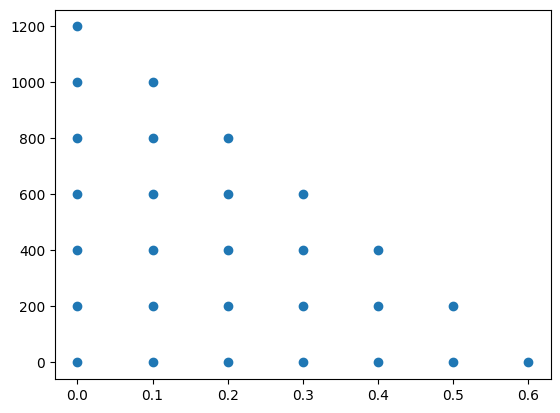

In [ ]:
l = 10
ranges = {
    'prob_thresh' : np.linspace(0, 1, l, endpoint = True),
    'bone_thresh' : np.array([200]),
    'size_thresh' : np.linspace(0, 2000, l, endpoint = True)
}

combis2 = []
for i, x in enumerate(ranges['prob_thresh']):
        for k, z in enumerate(ranges['size_thresh']):
            if i <= k:
                k = l-k-1
                combis2.append(np.array((ranges['prob_thresh'][i], ranges['bone_thresh'][0], ranges['size_thresh'][k])))
combis2 = np.array(combis2)

print(len(combis2))

plt.scatter(combis2.T[0], combis2.T[2])

In [ ]:
# append an array to an array


In [ ]:
device = 'cpu'

img_ids = os.listdir(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))
combis = combis2 #list(product(*ranges.values()))
gs = pd.DataFrame(columns = ranges.keys(), data = combis)

for metric in ['accuracy', 'precision', 'recall']:
    gs[metric] = [[] for _ in range(len(gs))]

y_pred_nonzero = np.array([])

for img_id in img_ids:
    x, _ = read_image(os.path.join(postprocess_args.original_image_dir, 'raw', postprocess_args.split, 'images', f'{img_id}-image.nii.gz'))
    y_pred = np.load(os.path.join(postprocess_args.save_dir, f'{img_id}_pred.npy'))
    y_true, _ = read_image(os.path.join(postprocess_args.original_image_dir, 'raw', postprocess_args.split, 'labels', f'{img_id}-label.nii.gz'))
    y_true = torch.tensor(simplify_labels(y_true), device = device, dtype = torch.int)

    # y_pred_nonzero.append(y_pred[y_pred != 0])
    y_pred_nonzero = np.append(y_pred_nonzero, y_pred[y_pred != 0])
    
    for i, combi in tqdm(gs.iterrows(), total=len(gs)):
        prob_thresh, bone_thresh, size_thresh = combi[:3]

        y_pred_post = _post_process(pred = y_pred, image = x, prob_thresh=prob_thresh, bone_thresh=bone_thresh, size_thresh=size_thresh)
        y_pred_post = torch.tensor(simplify_labels(y_pred_post), device = device, dtype = torch.int)
        
        metric = calculate_metrics(y_true, y_pred_post)
        
        for k, v in metric.items():
            gs.loc[i, k].append(v)

    gs.to_csv('../store/grid_search.csv')
    np.save('../store/y_pred_nonzero.npy', y_pred_nonzero)

gs['accuracy_mean'] = gs['accuracy'].apply(lambda x: np.mean(x))
gs['precision_mean'] = gs['precision'].apply(lambda x: np.mean(x))
gs['recall_mean'] = gs['recall'].apply(lambda x: np.mean(x))
gs['accuracy_std'] = gs['accuracy'].apply(lambda x: np.std(x))
gs['precision_std'] = gs['precision'].apply(lambda x: np.std(x))
gs['recall_std'] = gs['recall'].apply(lambda x: np.std(x))


gs.to_csv('../store/grid_search.csv')
np.save('../store/y_pred_nonzero.npy', y_pred_nonzero)

100%|██████████| 28/28 [01:05<00:00,  2.33s/it]


    prob_thresh  bone_thresh  size_thresh              accuracy  \
0           0.0        200.0       1200.0  [0.9995083808898926]   
1           0.0        200.0       1000.0  [0.9995083808898926]   
2           0.0        200.0        800.0  [0.9995083808898926]   
3           0.0        200.0        600.0  [0.9995083808898926]   
4           0.0        200.0        400.0  [0.9995083808898926]   
5           0.0        200.0        200.0  [0.9995083808898926]   
6           0.0        200.0          0.0  [0.9995083808898926]   
7           0.1        200.0       1000.0  [0.9997628927230835]   
8           0.1        200.0        800.0  [0.9997628927230835]   
9           0.1        200.0        600.0  [0.9997628927230835]   
10          0.1        200.0        400.0  [0.9997632503509521]   
11          0.1        200.0        200.0  [0.9997429251670837]   
12          0.1        200.0          0.0  [0.9997293949127197]   
13          0.2        200.0        800.0  [0.9997628927230835

100%|██████████| 28/28 [00:59<00:00,  2.11s/it]

    prob_thresh  bone_thresh  size_thresh  \
0           0.0        200.0       1200.0   
1           0.0        200.0       1000.0   
2           0.0        200.0        800.0   
3           0.0        200.0        600.0   
4           0.0        200.0        400.0   
5           0.0        200.0        200.0   
6           0.0        200.0          0.0   
7           0.1        200.0       1000.0   
8           0.1        200.0        800.0   
9           0.1        200.0        600.0   
10          0.1        200.0        400.0   
11          0.1        200.0        200.0   
12          0.1        200.0          0.0   
13          0.2        200.0        800.0   
14          0.2        200.0        600.0   
15          0.2        200.0        400.0   
16          0.2        200.0        200.0   
17          0.2        200.0          0.0   
18          0.3        200.0        600.0   
19          0.3        200.0        400.0   
20          0.3        200.0        200.0   
21        

Analysis

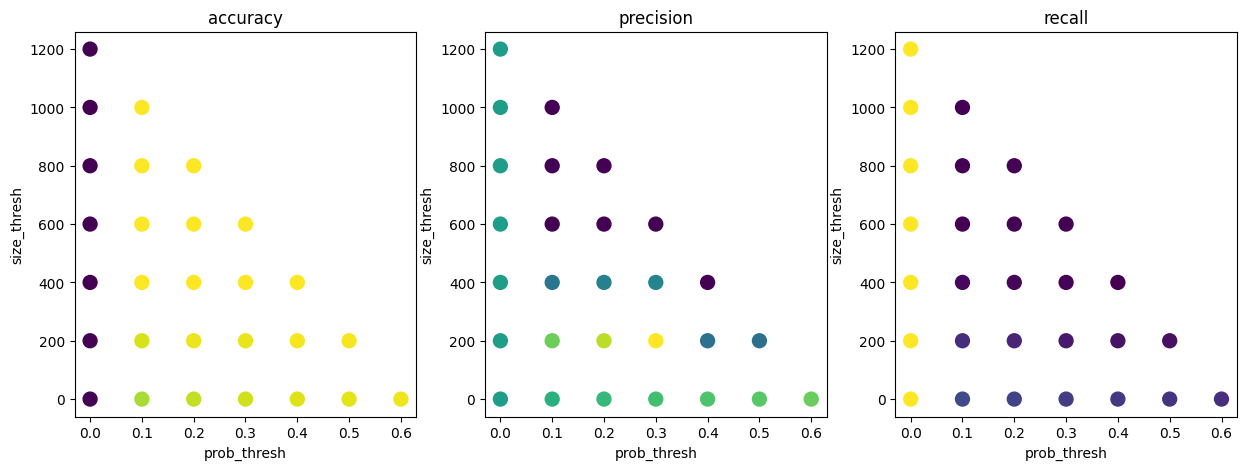

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    axs[i].scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    axs[i].set_xlabel('prob_thresh')
    axs[i].set_ylabel('size_thresh')
    axs[i].set_title(metric)
    


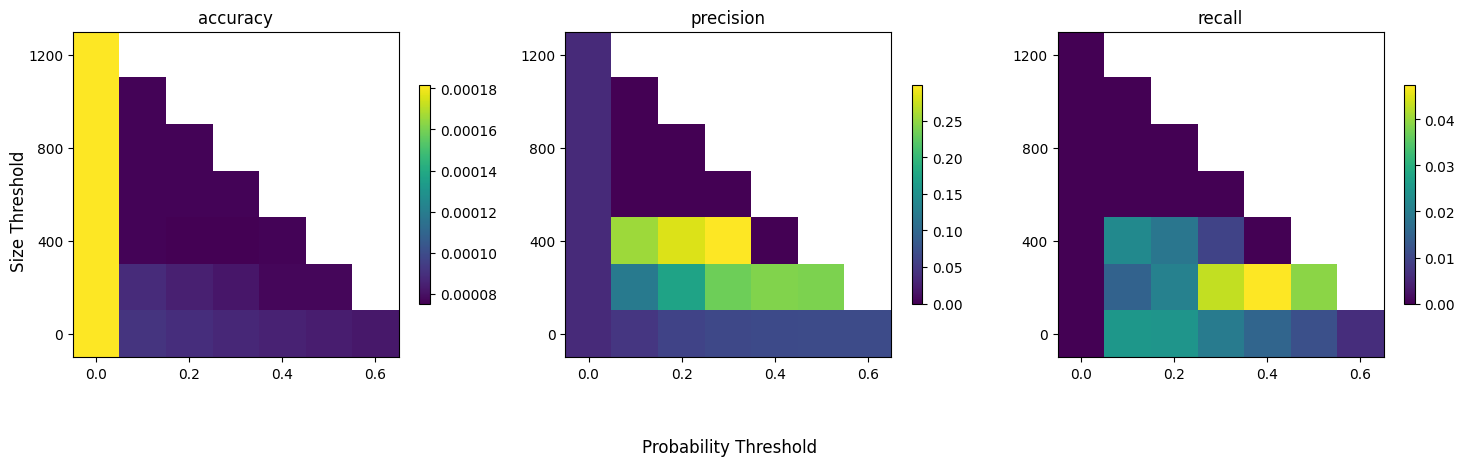

In [ ]:
metric_stats = ['mean', 'std']
for metric_stat in metric_stats:
    prob_thresh_values = gs['prob_thresh'].unique()
    size_thresh_values = gs['size_thresh'].unique()

    combis = combis2
    metrics = {k : np.zeros((len(prob_thresh_values), len(size_thresh_values))) for k in ['accuracy', 'precision', 'recall']}

    for i , prob_thresh_value in enumerate(prob_thresh_values):
        for j, size_thresh_value in enumerate(size_thresh_values):
            x = gs[(gs['prob_thresh'] == prob_thresh_value) & (gs['size_thresh'] == size_thresh_value)]
            if len(x) == 0:
                metrics['accuracy'][i, j] = np.nan
                metrics['precision'][i, j] = np.nan
                metrics['recall'][i, j] = np.nan
            else:
                metrics['accuracy'][i, j] = x.iloc[0][f'accuracy_{metric_stat}']
                metrics['precision'][i, j] = x.iloc[0][f'precision_{metric_stat}']
                metrics['recall'][i, j] = x.iloc[0][f'recall_{metric_stat}']

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    for i, metric in enumerate(['accuracy', 'precision', 'recall']):
        ax = axs[i]
        cmap = ax.imshow(metrics[metric].T, cmap = 'viridis')
        fig.colorbar(cmap, ax=ax, shrink=0.5)


        ax.set_yticks(np.arange(len(size_thresh_values))[::2])
        ax.set_xticks(np.arange(len(prob_thresh_values))[::2])
        ax.set_yticklabels(np.round(size_thresh_values).astype(int)[::2])
        ax.set_xticklabels(np.round(prob_thresh_values, 2)[::2])
        ax.set_title(metric)
    fig.supylabel('Size Threshold')
    fig.supxlabel('Probability Threshold')
    plt.show()

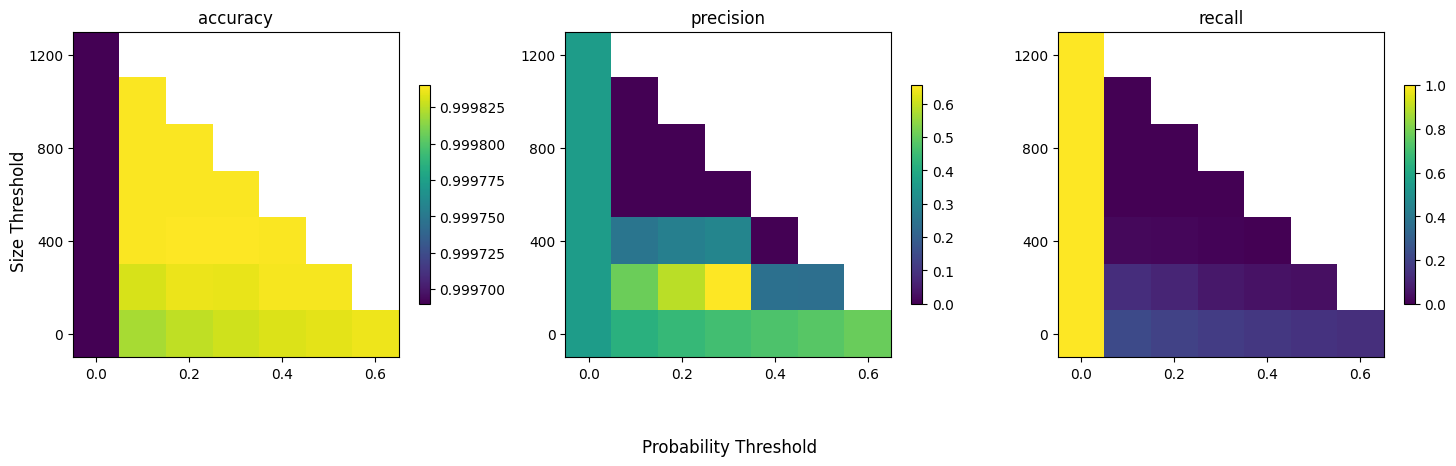